## Few Shot Evaluation

In [5]:
import sys
import os
sys.path.append('..')

from Parser import parse_LLM_output
from evaluate_tasks import *
import json
from nltk.sem.logic import *
import nltk
from nltk.sem.logic import LogicParser, Expression
from nltk.sem.evaluate import Valuation, Model
import pandas as pd

## Evaluation (via Parsers)

In [6]:
files = [f for f in os.listdir('../results/fewshot-eval/') if f.endswith('.json')]
print(len(files))

45


In [ ]:
results =[]
for f in files:
    names = f.split('_')
    model_name = names[0]
    task_name = names[1]
    task_name = os.path.splitext(task_name)[0]

    dataset = pd.read_json('../results/fewshot-eval/' + f)

    if "task1" in task_name:
        correctIncorrect, gibberish = eval_task1(dataset)
    elif "task2" in task_name:
        correctIncorrect, gibberish = eval_task2(dataset)
    elif "task3" in task_name:
        correctIncorrect, gibberish = eval_task3(dataset)

    # add two new columns to df and change original file
    dataset['Correct'] = correctIncorrect
    dataset['Gibberish'] = gibberish
    dataset.to_json('../results/fewshot-eval/' + f)
    # correctIncorrect = dataset['Correct']
    # gibberish = dataset['Gibberish']

    # calculate overall acc + acc without gibberish
    accuracy = sum(correctIncorrect) / len(correctIncorrect)
    print(accuracy)
    if accuracy > 0.0:
        accuracyNoGibberish = sum(correctIncorrect) / (len(correctIncorrect) - sum(gibberish))
    else:
        accuracyNoGibberish = 0.0
    
    results.append({'Task': task_name, 'Model': model_name, 'Accuracy': accuracy, 'AccuracyNoGibberish': accuracyNoGibberish})


#### Table / Summary:

In [8]:
summary_df = pd.DataFrame(results, columns=['Task', 'Model', 'Accuracy', 'AccuracyNoGibberish'])
summary_df = summary_df.pivot(index='Model', columns='Task', values=['Accuracy', 'AccuracyNoGibberish'])

display(summary_df)

Accuracy                                           
Task                task1-fs1 task1-fs2 task1-fs4 task2-fs1 task2-fs2   
Model                                                                   
Llama-2-13b-chat-hf     0.152     0.255     0.398     0.007     0.087  \
Wizard-15b              0.240     0.365     0.500     0.391     0.388   
falcon-7b               0.299     0.370     0.346     0.162     0.247   
flan-ul2                0.000     0.000     0.002     0.000     0.000   
orca-13b                0.233     0.389     0.499     0.112     0.071   

                                                              
Task                task2-fs4 task3-fs1 task3-fs2 task3-fs4   
Model                                                         
Llama-2-13b-chat-hf     0.207     0.510     0.504     0.503  \
Wizard-15b              0.418     0.494     0.493     0.495   
falcon-7b               0.142     0.493     0.493     0.493   
flan-ul2                0.000     0.488     0.481     0.478   
orca-13b                0.416     0.492     0.504     0.509   

                    AccuracyNoGibberish                                 
Task                          task1-fs1 task1-fs2 task1-fs4 task2-fs1   
Model                                                                   
Llama-2-13b-chat-hf            0.346241  0.358650  0.429342  0.012891  \
Wizard-15b                     0.421793  0.425904  0.502513  0.658249   
falcon-7b                      0.378961  0.417136  0.362683  0.451253   
flan-ul2                       0.000000  0.000000  0.057143  0.000000   
orca-13b                       0.571078  0.468675  0.505572  0.227181   

                                                                       
Task                task2-fs2 task2-fs4 task3-fs1 task3-fs2 task3-fs4  
Model                                                                  
Llama-2-13b-chat-hf  0.223650  0.601744     0.510     0.504     0.503  
Wizard-15b           0.656514  0.654147     0.494     0.493     0.495  
falcon-7b            0.515658  0.554688     0.493     0.493     0.493  
flan-ul2             0.000000  0.000000     0.488     0.481     0.478  
orca-13b             0.257246  0.604651     0.492     0.504     0.509

In [9]:
import matplotlib.pyplot as plt

In [10]:
temp_df = pd.DataFrame(results, columns=['Task', 'Model', 'Accuracy', 'AccuracyNoGibberish'])

In [11]:
temp_df_t1 = temp_df[temp_df["Task"].isin(["task1-fs1", "task1-fs2", "task1-fs4"])]

In [12]:
temp_df_t1_llama = temp_df_t1[temp_df_t1["Model"]=="Llama-2-13b-chat-hf"]
temp_df_t1_llama = temp_df_t1_llama.sort_values('Task')
temp_df_t1_llama

,Task,Model,Accuracy,AccuracyNoGibberish
4,task1-fs1,Llama-2-13b-chat-hf,0.152,0.346241
38,task1-fs2,Llama-2-13b-chat-hf,0.255,0.358650
30,task1-fs4,Llama-2-13b-chat-hf,0.398,0.429342


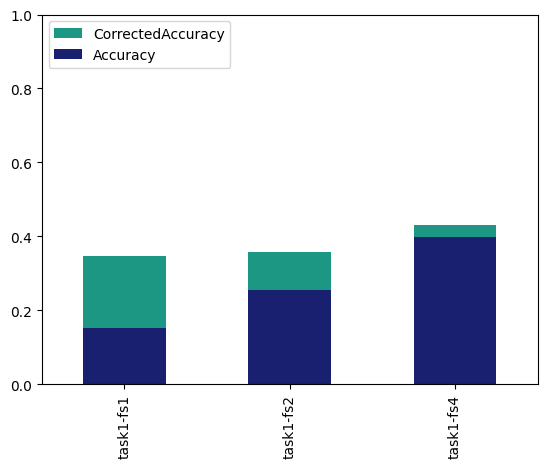

In [13]:
_, ax = plt.subplots()
temp_df_t1_llama["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t1_llama["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t1_llama['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [14]:
temp_df_t1_falcon = temp_df_t1[temp_df_t1["Model"]=="falcon-7b"]
temp_df_t1_falcon = temp_df_t1_falcon.sort_values('Task')
temp_df_t1_falcon

,Task,Model,Accuracy,AccuracyNoGibberish
22,task1-fs1,falcon-7b,0.299,0.378961
23,task1-fs2,falcon-7b,0.370,0.417136
37,task1-fs4,falcon-7b,0.346,0.362683


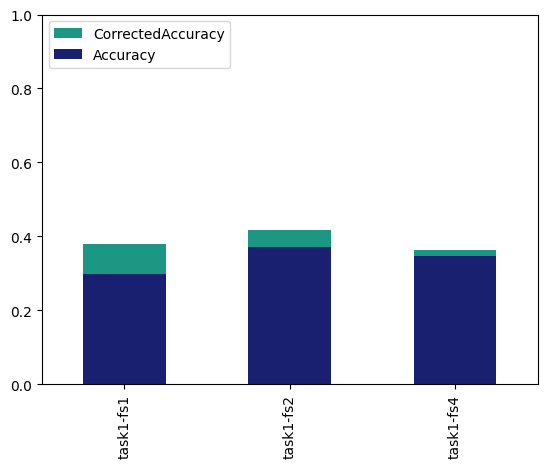

In [15]:
_, ax = plt.subplots()
temp_df_t1_falcon["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t1_falcon["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t1_falcon['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [16]:
temp_df_t1_ul2 = temp_df_t1[temp_df_t1["Model"]=="flan-ul2"]
temp_df_t1_ul2 = temp_df_t1_ul2.sort_values('Task')
temp_df_t1_ul2

,Task,Model,Accuracy,AccuracyNoGibberish
3,task1-fs1,flan-ul2,0.000,0.000000
44,task1-fs2,flan-ul2,0.000,0.000000
29,task1-fs4,flan-ul2,0.002,0.057143


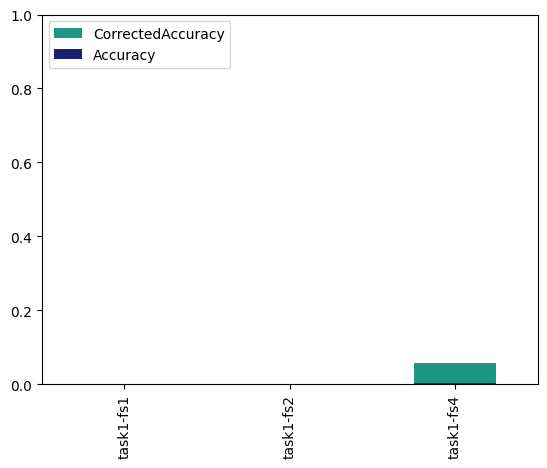

In [17]:
_, ax = plt.subplots()
temp_df_t1_ul2["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t1_ul2["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t1_ul2['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [18]:
temp_df_t1_orca = temp_df_t1[temp_df_t1["Model"]=="orca-13b"]
temp_df_t1_orca = temp_df_t1_orca.sort_values('Task')
temp_df_t1_orca

,Task,Model,Accuracy,AccuracyNoGibberish
28,task1-fs1,orca-13b,0.233,0.571078
19,task1-fs2,orca-13b,0.389,0.468675
2,task1-fs4,orca-13b,0.499,0.505572


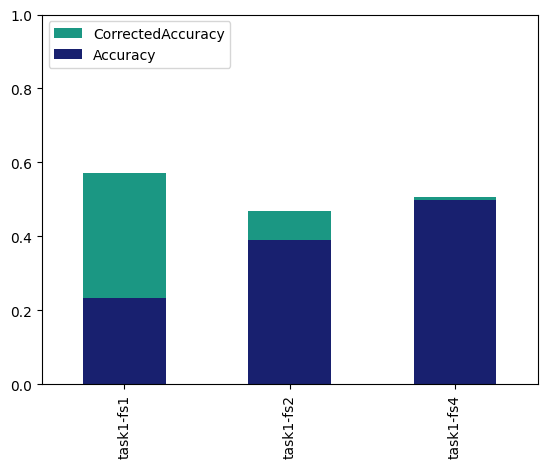

In [19]:
_, ax = plt.subplots()
temp_df_t1_orca["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t1_orca["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t1_orca['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [20]:
temp_df_t1_wizard = temp_df_t1[temp_df_t1["Model"]=="Wizard-15b"]
temp_df_t1_wizard = temp_df_t1_wizard.sort_values('Task')
temp_df_t1_wizard

,Task,Model,Accuracy,AccuracyNoGibberish
39,task1-fs1,Wizard-15b,0.240,0.421793
5,task1-fs2,Wizard-15b,0.365,0.425904
12,task1-fs4,Wizard-15b,0.500,0.502513


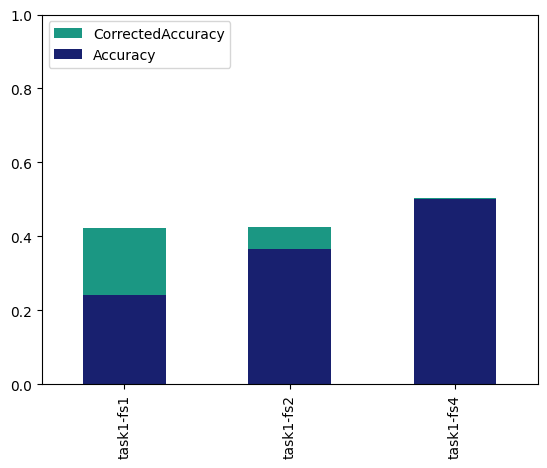

In [21]:
_, ax = plt.subplots()
temp_df_t1_wizard["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t1_wizard["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t1_wizard['Task'], rotation="vertical")
plt.legend(loc="upper left")

# Task 2

In [22]:
temp_df_t2 = temp_df[temp_df["Task"].isin(["task2-fs1", "task2-fs2", "task2-fs4"])]

In [23]:
temp_df_t2_llama = temp_df_t2[temp_df_t2["Model"]=="Llama-2-13b-chat-hf"]
temp_df_t2_llama = temp_df_t2_llama.sort_values('Task')
temp_df_t2_llama

,Task,Model,Accuracy,AccuracyNoGibberish
25,task2-fs1,Llama-2-13b-chat-hf,0.007,0.012891
15,task2-fs2,Llama-2-13b-chat-hf,0.087,0.223650
1,task2-fs4,Llama-2-13b-chat-hf,0.207,0.601744


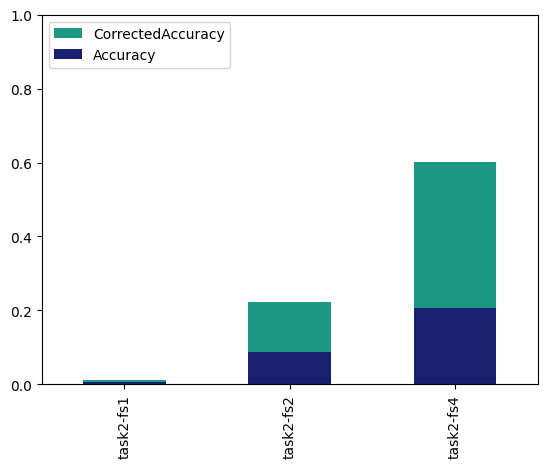

In [24]:
_, ax = plt.subplots()
temp_df_t2_llama["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t2_llama["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t2_llama['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [25]:
temp_df_t2_falcon = temp_df_t2[temp_df_t2["Model"]=="falcon-7b"]
temp_df_t2_falcon = temp_df_t2_falcon.sort_values('Task')
temp_df_t2_falcon

,Task,Model,Accuracy,AccuracyNoGibberish
35,task2-fs1,falcon-7b,0.162,0.451253
11,task2-fs2,falcon-7b,0.247,0.515658
20,task2-fs4,falcon-7b,0.142,0.554688


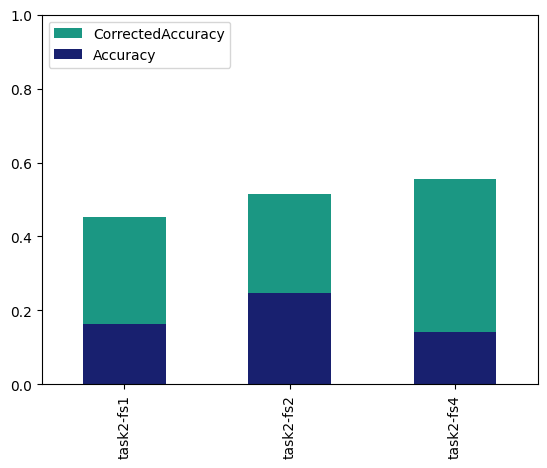

In [26]:
_, ax = plt.subplots()
temp_df_t2_falcon["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t2_falcon["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t2_falcon['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [27]:
temp_df_t2_ul2 = temp_df_t2[temp_df_t2["Model"]=="flan-ul2"]
temp_df_t2_ul2 = temp_df_t2_ul2.sort_values('Task')
temp_df_t2_ul2

,Task,Model,Accuracy,AccuracyNoGibberish
34,task2-fs1,flan-ul2,0.0,0.0
13,task2-fs2,flan-ul2,0.0,0.0
9,task2-fs4,flan-ul2,0.0,0.0


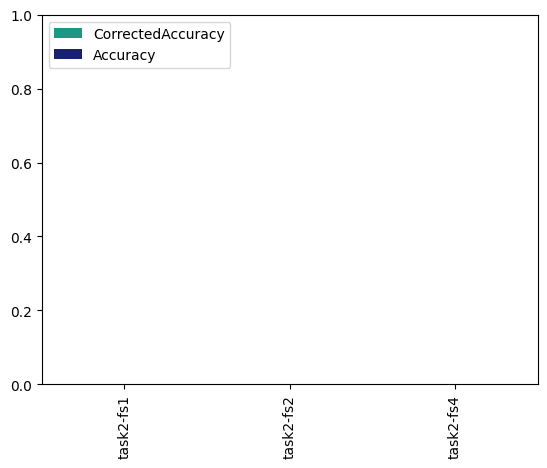

In [28]:
_, ax = plt.subplots()
temp_df_t2_ul2["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t2_ul2["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t2_ul2['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [32]:
temp_df_t2_orca = temp_df_t2[temp_df_t2["Model"]=="orca-13b"]
temp_df_t2_orca = temp_df_t2_orca.sort_values('Task')
temp_df_t2_orca

,Task,Model,Accuracy,AccuracyNoGibberish
6,task2-fs1,orca-13b,0.112,0.227181
41,task2-fs2,orca-13b,0.071,0.257246
31,task2-fs4,orca-13b,0.416,0.604651


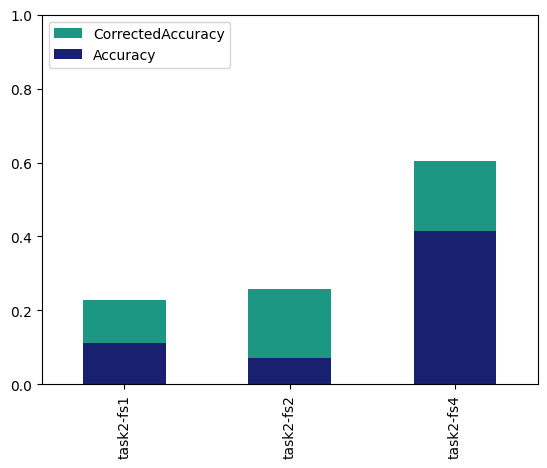

In [33]:
_, ax = plt.subplots()
temp_df_t2_orca["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t2_orca["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t2_orca['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [34]:
temp_df_t2_wizard = temp_df_t2[temp_df_t2["Model"]=="Wizard-15b"]
temp_df_t2_wizard = temp_df_t2_wizard.sort_values('Task')
temp_df_t2_wizard

,Task,Model,Accuracy,AccuracyNoGibberish
17,task2-fs1,Wizard-15b,0.391,0.658249
27,task2-fs2,Wizard-15b,0.388,0.656514
42,task2-fs4,Wizard-15b,0.418,0.654147


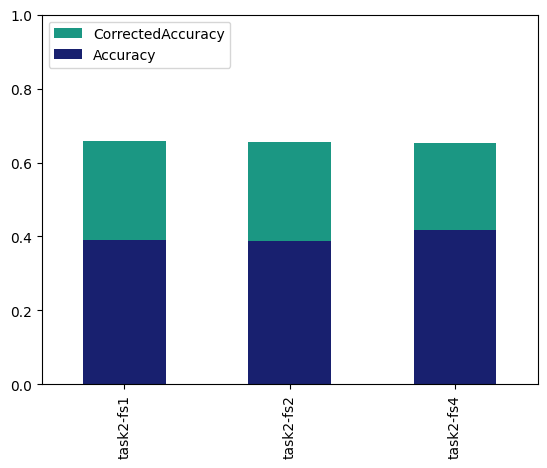

In [35]:
_, ax = plt.subplots()
temp_df_t2_wizard["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t2_wizard["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t2_wizard['Task'], rotation="vertical")
plt.legend(loc="upper left")

# Task 3

In [36]:
temp_df_t3 = temp_df[temp_df["Task"].isin(["task3-fs1", "task3-fs2", "task3-fs4"])]

In [37]:
temp_df_t3_llama = temp_df_t3[temp_df_t3["Model"]=="Llama-2-13b-chat-hf"]
temp_df_t3_llama = temp_df_t3_llama.sort_values('Task')
temp_df_t3_llama

,Task,Model,Accuracy,AccuracyNoGibberish
24,task3-fs1,Llama-2-13b-chat-hf,0.510,0.510
16,task3-fs2,Llama-2-13b-chat-hf,0.504,0.504
0,task3-fs4,Llama-2-13b-chat-hf,0.503,0.503


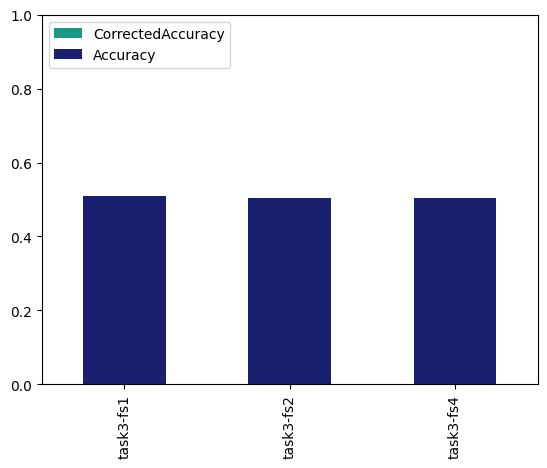

In [38]:
_, ax = plt.subplots()
temp_df_t3_llama["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t3_llama["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t3_llama['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [39]:
temp_df_t3_falcon = temp_df_t3[temp_df_t3["Model"]=="falcon-7b"]
temp_df_t3_falcon = temp_df_t3_falcon.sort_values('Task')
temp_df_t3_falcon

,Task,Model,Accuracy,AccuracyNoGibberish
36,task3-fs1,falcon-7b,0.493,0.493
10,task3-fs2,falcon-7b,0.493,0.493
21,task3-fs4,falcon-7b,0.493,0.493


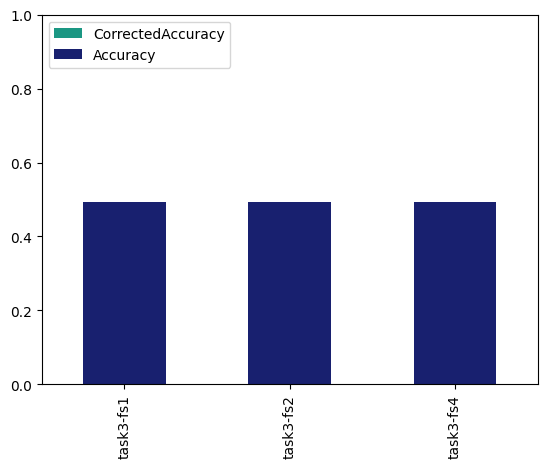

In [40]:
_, ax = plt.subplots()
temp_df_t3_falcon["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t3_falcon["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t3_falcon['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [41]:
temp_df_t3_ul2 = temp_df_t3[temp_df_t3["Model"]=="flan-ul2"]
temp_df_t3_ul2 = temp_df_t3_ul2.sort_values('Task')
temp_df_t3_ul2

,Task,Model,Accuracy,AccuracyNoGibberish
33,task3-fs1,flan-ul2,0.488,0.488
14,task3-fs2,flan-ul2,0.481,0.481
8,task3-fs4,flan-ul2,0.478,0.478


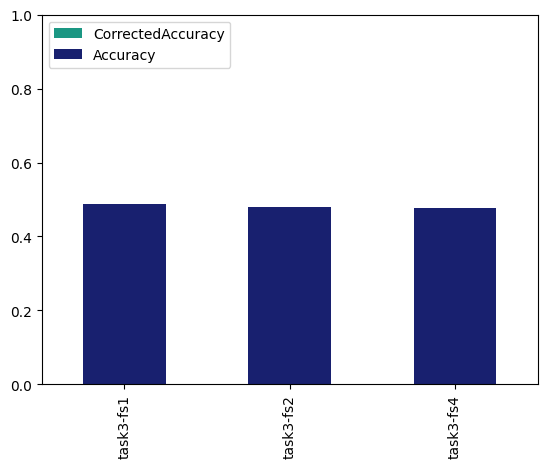

In [42]:
_, ax = plt.subplots()
temp_df_t3_ul2["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t3_ul2["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t3_ul2['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [43]:
temp_df_t3_orca = temp_df_t3[temp_df_t3["Model"]=="orca-13b"]
temp_df_t3_orca = temp_df_t3_orca.sort_values('Task')
temp_df_t3_orca

,Task,Model,Accuracy,AccuracyNoGibberish
7,task3-fs1,orca-13b,0.492,0.492
40,task3-fs2,orca-13b,0.504,0.504
32,task3-fs4,orca-13b,0.509,0.509


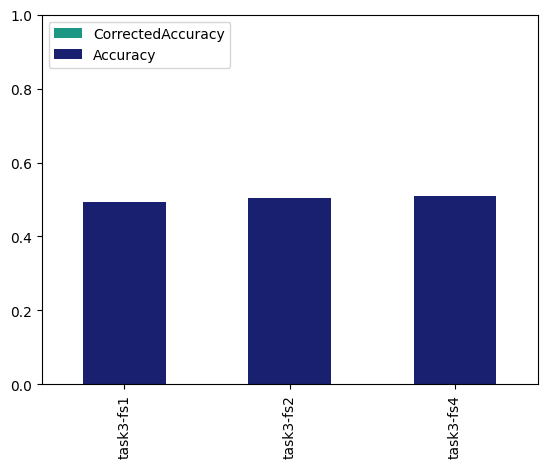

In [44]:
_, ax = plt.subplots()
temp_df_t3_orca["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t3_orca["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t3_orca['Task'], rotation="vertical")
plt.legend(loc="upper left")

In [45]:
temp_df_t3_wizard = temp_df_t3[temp_df_t3["Model"]=="flan-ul2"]
temp_df_t3_wizard = temp_df_t3_wizard.sort_values('Task')
temp_df_t3_wizard

,Task,Model,Accuracy,AccuracyNoGibberish
33,task3-fs1,flan-ul2,0.488,0.488
14,task3-fs2,flan-ul2,0.481,0.481
8,task3-fs4,flan-ul2,0.478,0.478


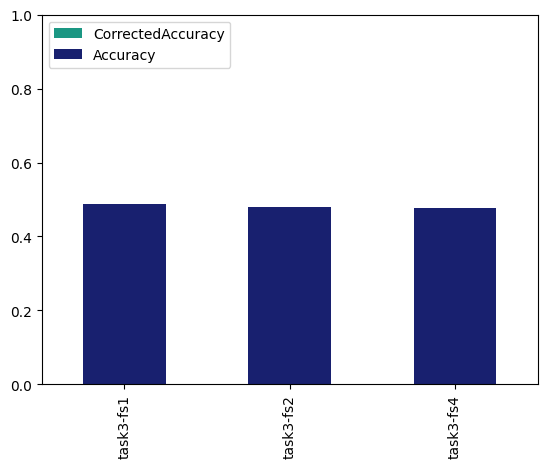

In [46]:
_, ax = plt.subplots()
temp_df_t3_wizard["AccuracyNoGibberish"].plot(kind='bar', ax=ax, color='#1B9783', ylim=(0, 1.0), label="CorrectedAccuracy")
temp_df_t3_wizard["Accuracy"].plot(kind='bar', ax=ax, color='#18206F', ylim=(0, 1.0), label="Accuracy")
plt.xticks([0, 1, 2], temp_df_t3_wizard['Task'], rotation="vertical")
plt.legend(loc="upper left")